# Privacy Preserving Generative Model
This notebook aims to create a generative model which works in Python3

In [11]:
!pip install imageio
!pip install matplotlib
!pip install tqdm

In [5]:
import time, os

# Numpy
import numpy as np

# Tensorflow and keras layers
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, Conv2DTranspose
from tensorflow.keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import activations
from tensorflow.keras import backend

# To generate GIFs


import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time


from tqdm import tqdm

from IPython import display
#tf.reset_default_graph()

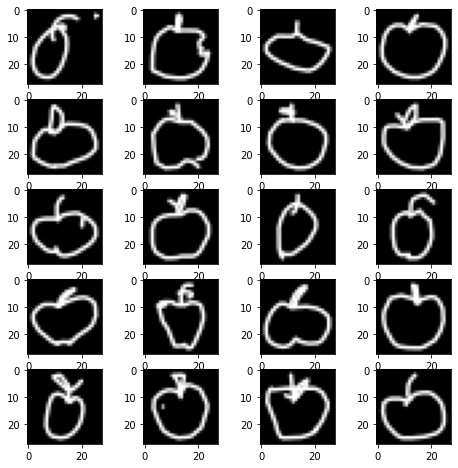

In [6]:
def preprocess_real_samples(samples):
    samples = samples.astype('float32').reshape(-1, 28, 28, 1)
    samples = (samples - samples.min()) / (samples.max() - samples.min())
    return samples

def plot_4_by_4_images(x, save = False, savefile="img.png"):
    w=10
    h=10
    fig=plt.figure(figsize=(8, 8))
    columns = 4
    rows = 5
    for i in range(1, columns*rows +1):
        img = np.random.randint(x.shape[0])
        fig.add_subplot(rows, columns, i)
        plt.imshow(x[i - 1, :, :, 0], cmap='gray')
    if save:
        plt.savefig(savefile)
    plt.show()
    
dataset = np.load('apple.npy')
dataset = preprocess_real_samples(dataset) 
plot_4_by_4_images(dataset)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 12544)             1254400   
_________________________________________________________________
batch_normalization_3 (Batch (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 12544)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_4 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 7, 7, 128)        

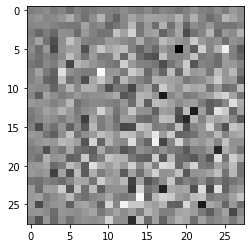

In [14]:
def generator_model():
    def square_activation(x):
        return x * x
    
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    #model.add(Activation(square_activation))

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    #model.add(Activation(square_activation))    

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    #model.add(Activation(square_activation))
    
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)
    model.compile(loss='binary_crossentropy', optimizer='adam')
    
    return model
noise = np.random.normal(0, 1, [1, 100])
generator = generator_model()
generator.summary()
generated_image = generator.predict(noise)
print(generated_image.shape)
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [15]:
def discriminator_model():
    def square_activation(x):
        return x * x
    
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    #model.add(Activation(square_activation))
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    #model.add(Activation(square_activation))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
discriminator = discriminator_model()
discriminator.summary()
pred= discriminator.predict(generated_image)
print(pred, pred > 0.5)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6272)             

In [16]:
def gan_model(generator, discriminator):
    discriminator.trainable=False
    gan_input = Input(shape=(100,))
    x = generator(gan_input)
    gan_output = discriminator(x)
    gan= Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer='adam')
    return gan

gan = gan_model(generator, discriminator)
gan.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 28, 28, 1)         2330944   
_________________________________________________________________
sequential_3 (Sequential)    (None, 1)                 212865    
Total params: 2,543,809
Trainable params: 2,305,472
Non-trainable params: 238,337
_________________________________________________________________


In [17]:
def generate_noise_samples(n=1):
    noise = np.random.normal(0, 1, (n, 100))
    return noise
def generate_fake_samples(n=1):
    noise = generate_noise_samples(n)
    X = generator.predict(noise)
    return X

In [18]:
def generate_and_save_images(noise_test, epoch, batch):
    display.clear_output(wait=True)
    fake_images = generator.predict(noise_test)
    plot_4_by_4_images(fake_images, save=True, savefile='img/image_at_epoch_{:04d}_{:04d}.png'.format(epoch, batch))

In [19]:
def train_step(real_images, batch_size=64):
        real_label = np.ones((batch_size, 1))
        generated_images = generate_fake_samples(batch_size)
        generated_labels = np.zeros((batch_size, 1))
        X_dis = np.concatenate([real_images, generated_images])
        y_dis = np.zeros(2*batch_size)
        y_dis[:batch_size]=0.9
        
        discriminator.trainable = True
        discriminator.train_on_batch(X_dis, y_dis)
        #discriminator.train_on_batch(x_fake, y_fake)
        
        discriminator.trainable = False
        x_gan = generate_noise_samples(batch_size)
        y_gan = np.ones((batch_size, 1)) # We assume that we wanted true as answer from the discriminator
        gan.train_on_batch(x_gan, y_gan)

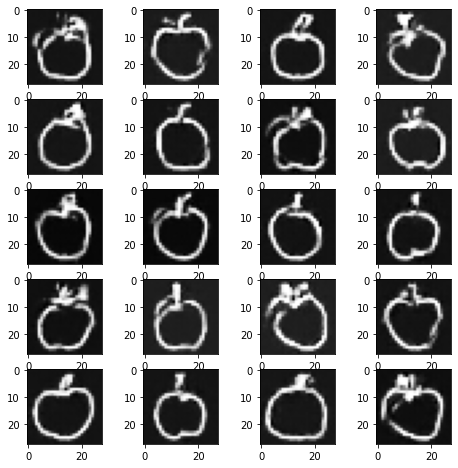

Time for epoch 500 is 5.856489181518555 sec


In [24]:
def train(dataset, epochs=50, batch_size=64):
    m = dataset.shape[0]
    m_batch = m // batch_size
    noise_test = np.random.normal(0,1, [20, 100])
    tic = time.time()
    for epoch in range(epochs):
        tic = time.time()
        for batch_num in tqdm(range(m_batch)):
            #if batch_num % 30 == 0:
                #print ('[{}%] Time for epoch {} is {} sec'.format((batch_num / m_batch) * 100,epoch + 1, time.time()-tic), end='\r')
                #generate_and_save_images(noise_test, epoch, batch_num)
                #print("[%0.2f%%] Time for epoch %d is %f sec" % ( (batch_num / m_batch) * 100, epoch + 1, time.time()-tic), end='\r')
                
            batch_slot = batch_size * batch_num
            batch = dataset[batch_slot: batch_slot + batch_size]
            train_step(batch, batch_size)
        #Extra
        if time.time() - tic  > 30:
            tic = time.time()
            generate_and_save_images(noise_test, epoch, batch_num)
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-tic))
    
    
train(dataset[:5000], 500, 32)

In [26]:
generator.save('generator_apple.h5')
discriminator.save('discriminator_apple.h5')
gan.save('gan_apple.h5')

In [3]:
from tensorflow.keras.models import load_model
generator = load_model('generator_apple.h5')
discriminator = load_model('discriminator_apple.h5')
gan = load_model('gan_apple.h5')

/root/he-transformer/build/ext_ngraph_tf/src/ext_ngraph_tf/build_cmake/venv-tf-py3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/root/he-transformer/build/ext_ngraph_tf/src/ext_ngraph_tf/build_cmake/venv-tf-py3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/root/he-transformer/build/ext_ngraph_tf/src/ext_ngraph_tf/build_cmake/venv-tf-py3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it wi

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


/root/he-transformer/build/ext_ngraph_tf/src/ext_ngraph_tf/build_cmake/venv-tf-py3/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/root/he-transformer/build/ext_ngraph_tf/src/ext_ngraph_tf/build_cmake/venv-tf-py3/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/root/he-transformer/build/ext_ngraph_tf/src/ext_ngraph_tf/build_cmake/venv-tf-py3/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future ve

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


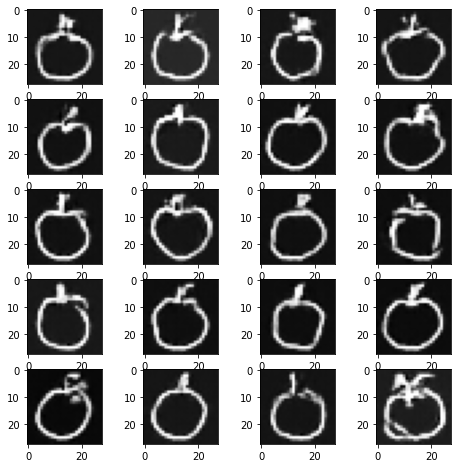

In [11]:
import numpy as np
fake_images = generator.predict(np.random.normal(0,1,[20, 100]))
plot_4_by_4_images(fake_images)

### EXTRA CODE

In [ ]:
BUFFER_SIZE = 60000
BATCH_SIZE = 64

dataset = np.load('apple.npy').astype('float32')

dataset = dataset.reshape(-1, 28, 28, 1)
dataset = (dataset - dataset.min()) / (dataset.max() - dataset.min())
train_dataset = tf.data.Dataset.from_tensor_slices(dataset).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
print(dataset.shape)
print(train_dataset)
plt.imshow(dataset[0, :, :, 0], cmap='gray')

def plot_4_by_4_images(x):
    w=10
    h=10
    fig=plt.figure(figsize=(8, 8))
    columns = 4
    rows = 5
    for i in range(1, columns*rows +1):
        img = np.random.randint(x.shape[0])
        fig.add_subplot(rows, columns, i)
        plt.imshow(x[img, :, :, 0], cmap='gray')
    plt.show()
plot_4_by_4_images(dataset)

In [ ]:

def discriminator_loss(real_output, fake_output):
    cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [ ]:
def generator_loss(fake_output):
    cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
# seed = tf.random.normal([num_examples_to_generate, noise_dim])

# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)


    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [ ]:
def generate_fake_image(n = 1):
    print("RANDOM")
    noise = tf.random.normal([n, 100])
    print("PREDICT")
    generated_image = generator.predict(noise, steps=1)
    return generated_image
tic = time.time()
fake = generate_fake_image()
#print(fake)q
print(time.time() - tic)
plt.imshow(fake[0,:,:,0], cmap='gray')

In [ ]:
def train(dataset, epochs):
    length = dataset.shape[0]
    print(length, length // BATCH_SIZE)
    for epoch in range(epochs):
        start = time.time()
        for i in range(0, length // BATCH_SIZE):
            image_batch = dataset[i:i+BATCH_SIZE]
            #print ('Time for batch {} is {} sec'.format(i, time.time()-start))
            train_step(image_batch)
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    fake_images = generate_fake_image(16)
    print("Fake image generated")
    plot_4_by_4_images(fake_images)
train(dataset, EPOCHS)